In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pkg_resources
from ont_fast5_api.fast5_interface import get_fast5_file
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

/var/folders/sn/bhvg8vk93sb2vl2r4frl_j2m0000gn/T/ipykernel_24604/1800775903.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Locate FAST5 files

In [8]:
fast5_dir = "/Users/olisaogbue/Downloads/sample_fast5/workspace"

filepaths = [
    os.path.join(fast5_dir, f)
    for f in os.listdir(fast5_dir)
    if f.endswith(".fast5")
]

print("FAST5 files found:", len(filepaths))
print("Example:", filepaths[0] if filepaths else None)

FAST5 files found: 5
Example: /Users/olisaogbue/Downloads/sample_fast5/workspace/FAK42335_2bf4f211a2e2d04662e50f27448cfd99dafbd7ee_100.fast5


FAST5 read loader

In [9]:
def load_fast5(path, include_read_ids=None):
    """
    Loads reads from a single FAST5 file.

    Returns:
      outputs: list of (raw_current, meta_dict)
    """
    outputs = []
    with get_fast5_file(path, mode="r") as f5:
        for read_id in f5.get_read_ids():
            if include_read_ids is not None and read_id not in include_read_ids:
                continue

            read = f5.get_read(read_id)

            # raw signal
            raw_signal = read.get_raw_data()

            # channel calibration info
            ch = read.get_channel_info()
            sampling_rate = ch["sampling_rate"]
            channel_number = ch["channel_number"]
            digitisation = ch["digitisation"]
            range_current = ch["range"]
            offset = ch["offset"]

            # convert ADC to pA-like current
            raw_current = (raw_signal + offset) * range_current / digitisation
            raw_current = raw_current.astype(np.float32)

            tracking = dict(read.get_tracking_id()) if hasattr(read, "get_tracking_id") else {}
            context_tags = dict(read.get_context_tags()) if hasattr(read, "get_context_tags") else {}

            raw_group = read.handle["Raw"]
            start_time = raw_group.attrs.get("start_time")
            duration = raw_group.attrs.get("duration")
            read_number = raw_group.attrs.get("read_number")

            duration_seconds = float(duration) / float(sampling_rate) if duration is not None else None

            meta = {
                "file": path,
                "read_id": read_id,
                "sampling_rate_hz": float(sampling_rate),
                "channel_number": int(channel_number) if channel_number is not None else None,
                "start_time": int(start_time) if start_time is not None else None,
                "duration": int(duration) if duration is not None else None,
                "duration_seconds": duration_seconds,
                "read_number": int(read_number) if read_number is not None else None,
                "tracking_id": tracking,
                "context_tags": context_tags,
            }

            outputs.append((raw_current, meta))

    return outputs


Build a global pool of read_ids and sample 2000

In [10]:
all_read_ids = []
for path in filepaths:
    with get_fast5_file(path, "r") as f5:
        all_read_ids.extend(f5.get_read_ids())

print("Total read_ids found:", len(all_read_ids))

num_reads = 2000
rng = np.random.default_rng(42)
num_reads = min(num_reads, len(all_read_ids))

sample_read_ids = set(rng.choice(np.array(all_read_ids), size=num_reads, replace=False))
print("Sampled read_ids:", len(sample_read_ids))

Total read_ids found: 20000
Sampled read_ids: 2000


Load the sampled reads

In [12]:
signals, metas = [], []

for path in filepaths:
    for signal, meta in load_fast5(path, include_read_ids=sample_read_ids):
        signals.append(signal)
        metas.append(meta)

df = pd.DataFrame(metas)

print("Reads loaded:", len(signals))
print("Unique read_ids:", df["read_id"].nunique())
df.head()

Reads loaded: 2000
Unique read_ids: 2000


,file,read_id,sampling_rate_hz,channel_number,start_time,duration,duration_seconds,read_number,tracking_id,context_tags
0,/Users/olisaogbue/Downloads/sample_fast5/works...,016728c9-93a7-43b2-8f2c-f576870158e4,4000.0,60,31187896,24044,6.01100,3396,"{'asic_id': '3775604239', 'asic_id_eeprom': '2...","{'experiment_duration_set': '2880', 'experimen..."
1,/Users/olisaogbue/Downloads/sample_fast5/works...,01878ec0-dff3-403e-8fbd-57e209a8fd31,4000.0,452,31068388,22930,5.73250,3022,"{'asic_id': '3775604239', 'asic_id_eeprom': '2...","{'experiment_duration_set': '2880', 'experimen..."
2,/Users/olisaogbue/Downloads/sample_fast5/works...,01a0b441-6dbe-4e15-87e6-fa568d42ccbd,4000.0,374,30906592,73428,18.35700,2521,"{'asic_id': '3775604239', 'asic_id_eeprom': '2...","{'experiment_duration_set': '2880', 'experimen..."
3,/Users/olisaogbue/Downloads/sample_fast5/works...,01afbc3e-89a0-475c-8acc-4c64ded621fa,4000.0,480,31051893,27436,6.85900,2946,"{'asic_id': '3775604239', 'asic_id_eeprom': '2...","{'experiment_duration_set': '2880', 'experimen..."
4,/Users/olisaogbue/Downloads/sample_fast5/works...,024c96c3-bd75-47c8-94c8-8c12bdff61c7,4000.0,428,31052335,10493,2.62325,2738,"{'asic_id': '3775604239', 'asic_id_eeprom': '2...","{'experiment_duration_set': '2880', 'experimen..."


Plot check

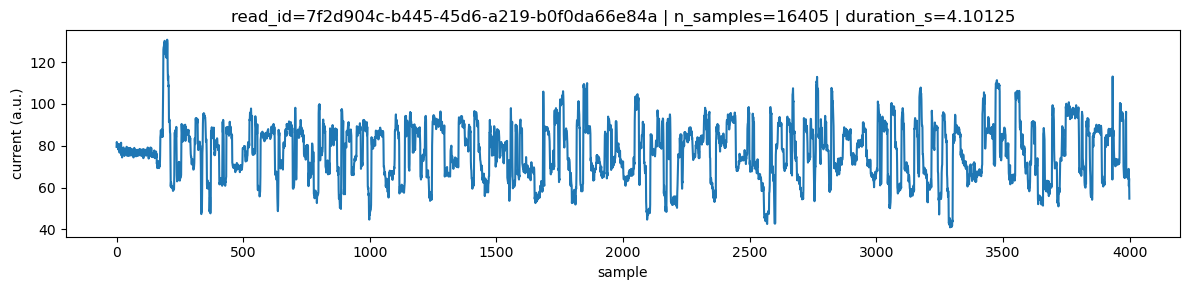

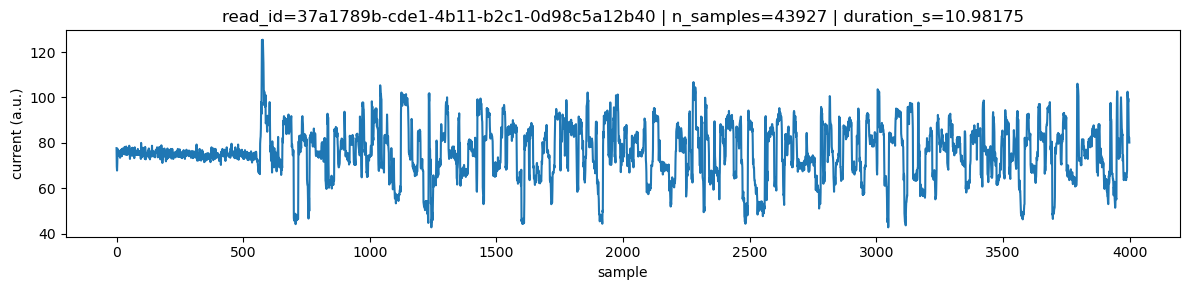

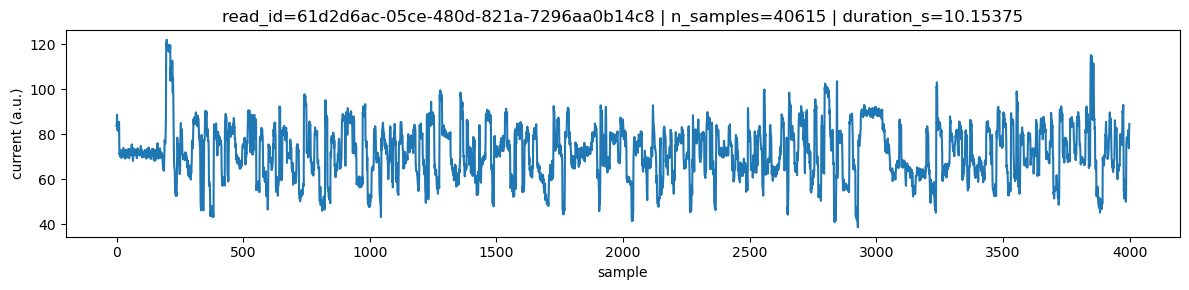

In [13]:
k = min(3, len(signals))
for i in random.sample(range(len(signals)), k=k):
    meta = metas[i]
    plt.figure(figsize=(12, 3))
    plt.plot(signals[i][:4000])
    plt.title(
        f"read_id={meta['read_id']} | n_samples={len(signals[i])} | "
        f"duration_s={meta['duration_seconds'] if meta['duration_seconds'] is not None else 'NA'}"
    )
    plt.xlabel("sample")
    plt.ylabel("current (a.u.)")
    plt.tight_layout()
    plt.show()

Preprocessing: MAD Normalisation, Windowing, and Dataset Statistics

MAD Normalisation

In [14]:
def mad_normalise(x, eps=1e-6):
    x = np.asarray(x, dtype=np.float32)
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + eps
    return (x - med) / mad

Windowing

In [15]:
def window_signal(x, window=4096, stride=512):
    x = np.asarray(x, dtype=np.float32)
    if len(x) < window:
        return np.empty((0, window), dtype=np.float32)

    n = 1 + (len(x) - window) // stride
    out = np.zeros((n, window), dtype=np.float32)

    for i in range(n):
        start = i * stride
        out[i] = x[start:start + window]

    return out

Apply Normalisation + Windowing Across Sampled Reads

In [16]:
X_list = []
window_read_ids = []

for path in filepaths:
    for signal, meta in load_fast5(path, include_read_ids=sample_read_ids):
        s_norm = mad_normalise(signal)
        w = window_signal(s_norm, window=4096, stride=512)

        if w.shape[0] == 0:
            continue

        X_list.append(w)
        window_read_ids.extend([meta["read_id"]] * w.shape[0])

X = np.vstack(X_list).astype(np.float32)
window_read_ids = np.array(window_read_ids)

print("X shape:", X.shape)
print("Unique reads represented:", len(np.unique(window_read_ids)))

X shape: (118242, 4096)
Unique reads represented: 1973


Dataset Stats

Windows per read summary:
count    1973.000000
mean       59.930056
std        28.528342
min         1.000000
25%        41.000000
50%        56.000000
75%        75.000000
max       227.000000
Name: count, dtype: float64


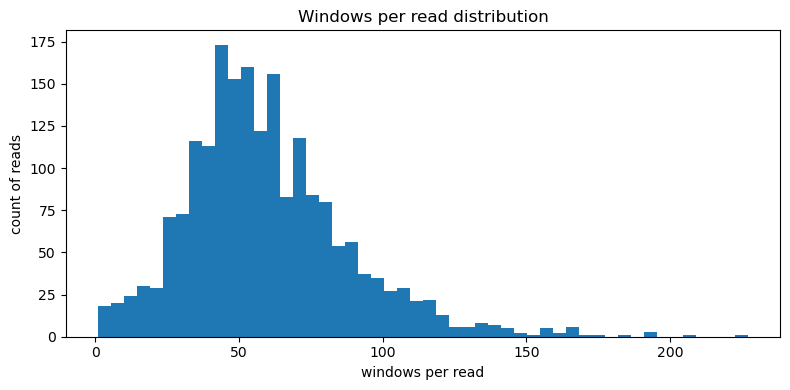

In [17]:
counts = pd.Series(window_read_ids).value_counts()
print("Windows per read summary:")
print(counts.describe())

plt.figure(figsize=(8,4))
plt.hist(counts.values, bins=50)
plt.title("Windows per read distribution")
plt.xlabel("windows per read")
plt.ylabel("count of reads")
plt.tight_layout()
plt.show()

Baseline Autoencoder: Training and Clean Reconstruction Evaluation

Device

In [18]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)


Device: mps


Load Processed Arrays

In [19]:
unique_reads = np.unique(window_read_ids)
rng = np.random.default_rng(42)
permutation = rng.permutation(unique_reads)

num = len(unique_reads)
num_train = int(0.70 * num)
num_val = int(0.15 * num)

train_reads = set(permutation[:num_train])
val_reads = set(permutation[num_train:num_train+num_val])
test_reads = set(permutation[num_train+num_val:])

train_indx = np.where(np.isin(window_read_ids, list(train_reads)))[0]
val_indx   = np.where(np.isin(window_read_ids, list(val_reads)))[0]
test_indx  = np.where(np.isin(window_read_ids, list(test_reads)))[0]

X_train, X_val, X_test = X[train_indx], X[val_indx], X[test_indx]
readid_train, readid_val, readid_test = window_read_ids[train_indx], window_read_ids[val_indx], window_read_ids[test_indx]

Dataset and DataLoaders

In [20]:
class WindowDataset(Dataset):
    def __init__(self, X: np.ndarray):
        self.X = torch.from_numpy(np.asarray(X, dtype=np.float32))
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx]

def make_loader(X: np.ndarray, batch_size: int, shuffle: bool) -> DataLoader:
    ds = WindowDataset(X)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False, num_workers=0, pin_memory=False)

train_dl = make_loader(X_train, batch_size=128, shuffle=True)
val_dl   = make_loader(X_val,   batch_size=128, shuffle=False)
test_dl  = make_loader(X_test,  batch_size=128, shuffle=False)

Baseline Conv1D Autoencoder Architecture

In [21]:
class ConvAutoEncoder1D(nn.Module):
    def __init__(self, latent_channels: int = 64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=2, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv1d(16, 32, kernel_size=9, stride=2, padding=4),  
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4),   
            nn.ReLU(inplace=True),
            nn.Conv1d(64, latent_channels, kernel_size=9, stride=2, padding=4),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(latent_channels, 64, kernel_size=9, stride=2, padding=4, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=2, padding=4, output_padding=1),             
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=9, stride=2, padding=4, output_padding=1),             
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(16, 1, kernel_size=9, stride=2, padding=4, output_padding=1),              
        )

    def forward(self, x):
        x = x.unsqueeze(1)       
        z = self.encoder(x)
        y = self.decoder(z)
        return y.squeeze(1)       

Training

In [22]:
@torch.no_grad()
def evaluate_mse(model, dl):
    model.eval()
    total_sqerr = 0.0
    total_elems = 0
    for xb in dl:
        xb = xb.to(device)
        yb = model(xb)
        total_sqerr += torch.sum((yb - xb) ** 2).item()
        total_elems += xb.numel()
    return total_sqerr / total_elems

def train_autoencoder(
    model,
    train_dl,
    val_dl,
    epochs=30,
    patience=5,
    lr=1e-3,
    weight_decay=1e-4,
):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fun = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    bad = 0

    history = {"train": [], "val": []}

    for ep in range(1, epochs + 1):
        model.train()
        train_sqerr, train_elems = 0.0, 0

        for xb in train_dl:
            xb = xb.to(device)
            opt.zero_grad(set_to_none=True)
            yb = model(xb)
            loss = loss_fun(yb, xb)
            loss.backward()
            opt.step()

            train_sqerr += torch.sum((yb - xb) ** 2).item()
            train_elems += xb.numel()

        train_mse = train_sqerr / train_elems
        val_mse = evaluate_mse(model, val_dl)

        history["train"].append(train_mse)
        history["val"].append(val_mse)

        print(f"epoch {ep:02d} | train_mse {train_mse:.6f} | val_mse {val_mse:.6f}")

        if val_mse < best_val - 1e-6:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


Train Baseline Autoencoder

In [24]:
model = ConvAutoEncoder1D(latent_channels=64)
model, history = train_autoencoder(model, train_dl, val_dl, epochs=30, patience=5)

epoch 01 | train_mse 0.217086 | val_mse 0.091055
epoch 02 | train_mse 0.076747 | val_mse 0.060679
epoch 03 | train_mse 0.055860 | val_mse 0.046999
epoch 04 | train_mse 0.045493 | val_mse 0.039384
epoch 05 | train_mse 0.041822 | val_mse 0.051998
epoch 06 | train_mse 0.041452 | val_mse 0.034167
epoch 07 | train_mse 0.032326 | val_mse 0.027685
epoch 08 | train_mse 0.029668 | val_mse 0.022104
epoch 09 | train_mse 0.021784 | val_mse 0.017520
epoch 10 | train_mse 0.018001 | val_mse 0.018572
epoch 11 | train_mse 0.016659 | val_mse 0.010824
epoch 12 | train_mse 0.011193 | val_mse 0.014847
epoch 13 | train_mse 0.010990 | val_mse 0.005569
epoch 14 | train_mse 0.005099 | val_mse 0.002399
epoch 15 | train_mse 0.004007 | val_mse 0.002890
epoch 16 | train_mse 0.003970 | val_mse 0.003065
epoch 17 | train_mse 0.004127 | val_mse 0.001663
epoch 18 | train_mse 0.003782 | val_mse 0.006142
epoch 19 | train_mse 0.003926 | val_mse 0.002596
epoch 20 | train_mse 0.003137 | val_mse 0.002554
epoch 21 | train_mse

In [ ]:
Learning Curve

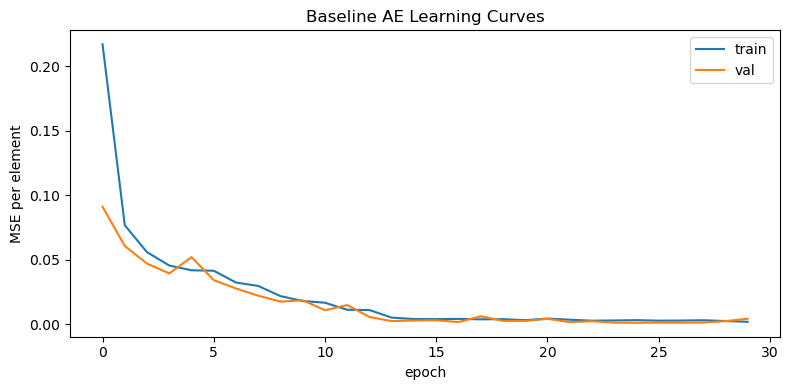

In [25]:
plt.figure(figsize=(8,4))
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.xlabel("epoch")
plt.ylabel("MSE per element")
plt.title("Baseline AE Learning Curves")
plt.legend()
plt.tight_layout()
plt.show()


Qualatative Reconstructions

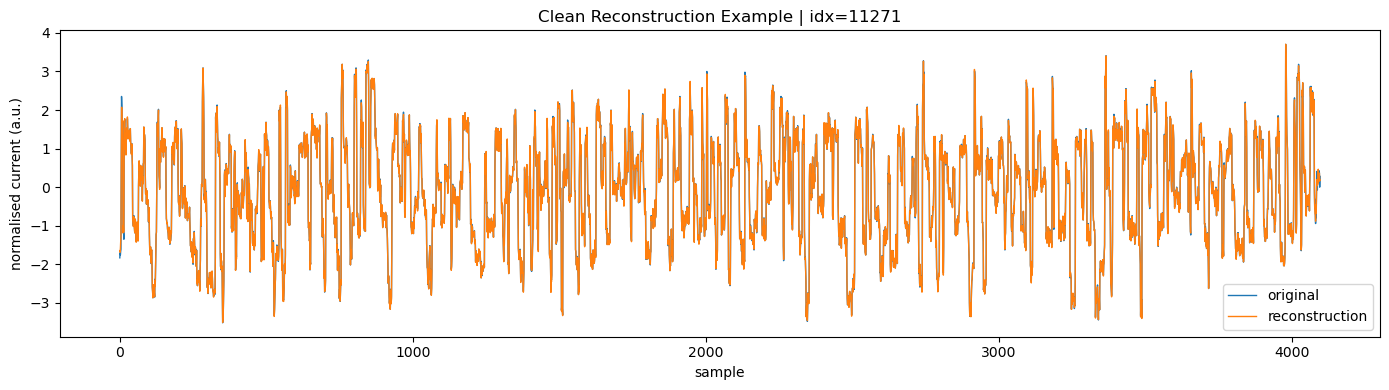

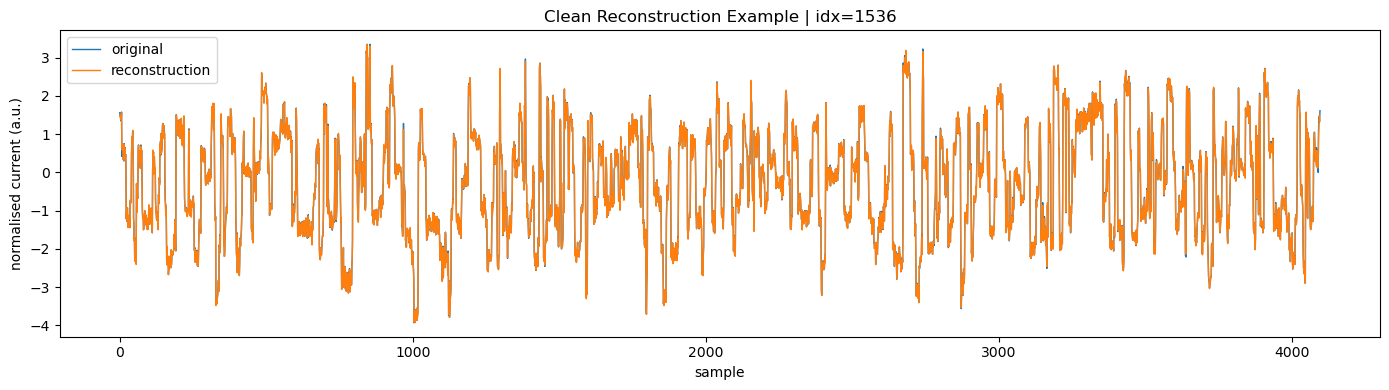

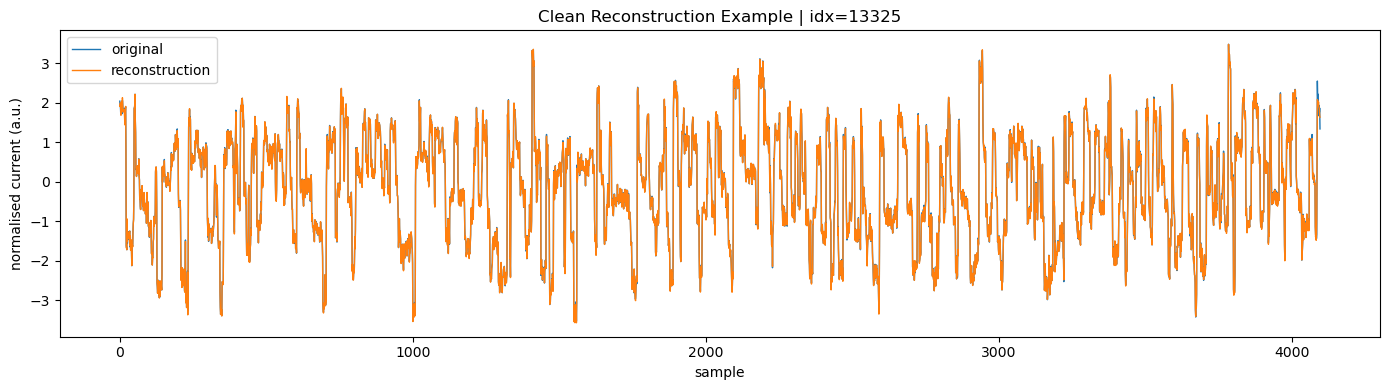

In [26]:
@torch.no_grad()
def reconstruct_examples(model, X, n=3, seed=0):
    rng = np.random.default_rng(seed)
    indexs = rng.choice(X.shape[0], size=min(n, X.shape[0]), replace=False)

    model.eval()
    for idx in indexs:
        x = torch.tensor(X[idx], dtype=torch.float32).unsqueeze(0).to(device)
        y = model(x).cpu().numpy()[0]
        x_np = X[idx]

        plt.figure(figsize=(14,4))
        plt.plot(x_np, label="original", linewidth=1)
        plt.plot(y, label="reconstruction", linewidth=1)
        plt.title(f"Clean Reconstruction Example | idx={idx}")
        plt.xlabel("sample")
        plt.ylabel("normalised current (a.u.)")
        plt.legend()
        plt.tight_layout()
        plt.show()

reconstruct_examples(model, X_test, n=3, seed=42)

Corruption

In [27]:
def corrupt(x, mode="mask", p=0.05, block=64, noise_scale=0.05):
    if mode == "none":
        return x

    if mode == "noise":
        std = torch.std(x, dim=1, keepdim=True) + 1e-6
        return x + noise_scale * std * torch.randn_like(x)

    if mode == "mask":
        B, L = x.shape
        out = x.clone()
        n_blocks = max(1, int((p * L) / block))
        
        for b in range(B):
            for _ in range(n_blocks):
                s = torch.randint(0, L - block + 1, (1,), device=x.device).item()
                out[b, s:s+block] = 0.0
        return out

    raise ValueError("mode must be one of: none, mask, noise")

Train Denoise Autoencoder

In [30]:
def train_denoising_autoencoder(
    model,
    train_dl,
    val_dl,
    *,
    epochs=30,
    patience=5,
    lr=1e-3,
    weight_decay=1e-4,
    corruption_mode="mask",
    mask_p=0.03,         
    mask_block=64,
    noise_scale=0.05
):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fun = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    bad = 0
    history = {"train": [], "val": []}

    for ep in range(1, epochs + 1):
        model.train()
        train_sqerr, train_elems = 0.0, 0

        for xb in train_dl:
            xb = xb.to(device)
            x_in = corrupt(xb, mode=corruption_mode, p=mask_p, block=mask_block, noise_scale=noise_scale)

            opt.zero_grad(set_to_none=True)
            yb = model(x_in)
            loss = loss_fun(yb, xb)
            loss.backward()
            opt.step()

            train_sqerr += torch.sum((yb - xb) ** 2).item()
            train_elems += xb.numel()

        train_mse = train_sqerr / train_elems
        val_mse = evaluate_mse(model, val_dl)

        history["train"].append(train_mse)
        history["val"].append(val_mse)

        print(f"epoch {ep:02d} | train_mse {train_mse:.6f} | val_mse {val_mse:.6f}")

        if val_mse < best_val - 1e-6:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


In [31]:
denoise_model = ConvAutoEncoder1D(latent_channels=64)

denoise_model, history = train_denoising_autoencoder(
    denoise_model,
    train_dl,
    val_dl,
    epochs=30,
    patience=5,
    corruption_mode="mask",
    mask_p=0.03,    
    mask_block=64
)

epoch 01 | train_mse 0.243605 | val_mse 0.103274
epoch 02 | train_mse 0.108363 | val_mse 0.063741
epoch 03 | train_mse 0.086789 | val_mse 0.051416
epoch 04 | train_mse 0.076186 | val_mse 0.048009
epoch 05 | train_mse 0.067212 | val_mse 0.034082
epoch 06 | train_mse 0.060193 | val_mse 0.027753
epoch 07 | train_mse 0.055588 | val_mse 0.025151
epoch 08 | train_mse 0.050199 | val_mse 0.036900
epoch 09 | train_mse 0.045124 | val_mse 0.014901
epoch 10 | train_mse 0.041166 | val_mse 0.018689
epoch 11 | train_mse 0.040113 | val_mse 0.008651
epoch 12 | train_mse 0.036947 | val_mse 0.006261
epoch 13 | train_mse 0.035478 | val_mse 0.005348
epoch 14 | train_mse 0.034104 | val_mse 0.003406
epoch 15 | train_mse 0.032256 | val_mse 0.007367
epoch 16 | train_mse 0.033594 | val_mse 0.002960
epoch 17 | train_mse 0.030749 | val_mse 0.002069
epoch 18 | train_mse 0.031414 | val_mse 0.019937
epoch 19 | train_mse 0.031771 | val_mse 0.002262
epoch 20 | train_mse 0.031425 | val_mse 0.002122
epoch 21 | train_mse

Learning Curves

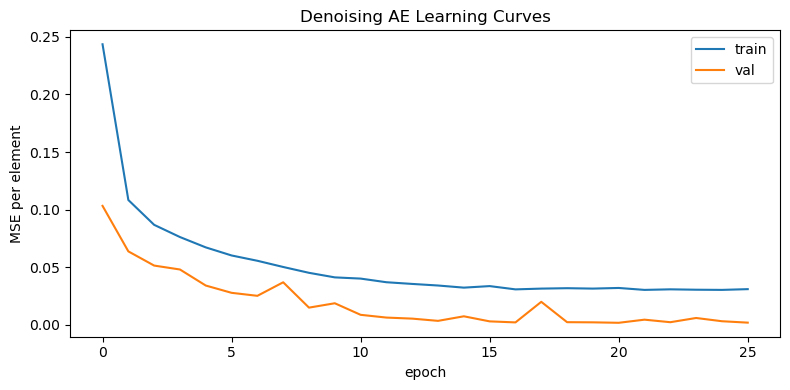

In [32]:
plt.figure(figsize=(8,4))
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.xlabel("epoch")
plt.ylabel("MSE per element")
plt.title("Denoising AE Learning Curves")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
denoise_test_mse = evaluate_mse(denoise_model, test_dl)
print(f"Denoising Autoencoder Reference MSE: {denoise_test_mse}")

Denoising Autoencoder Reference MSE: 0.0013434314363972985


Qualatative Plot

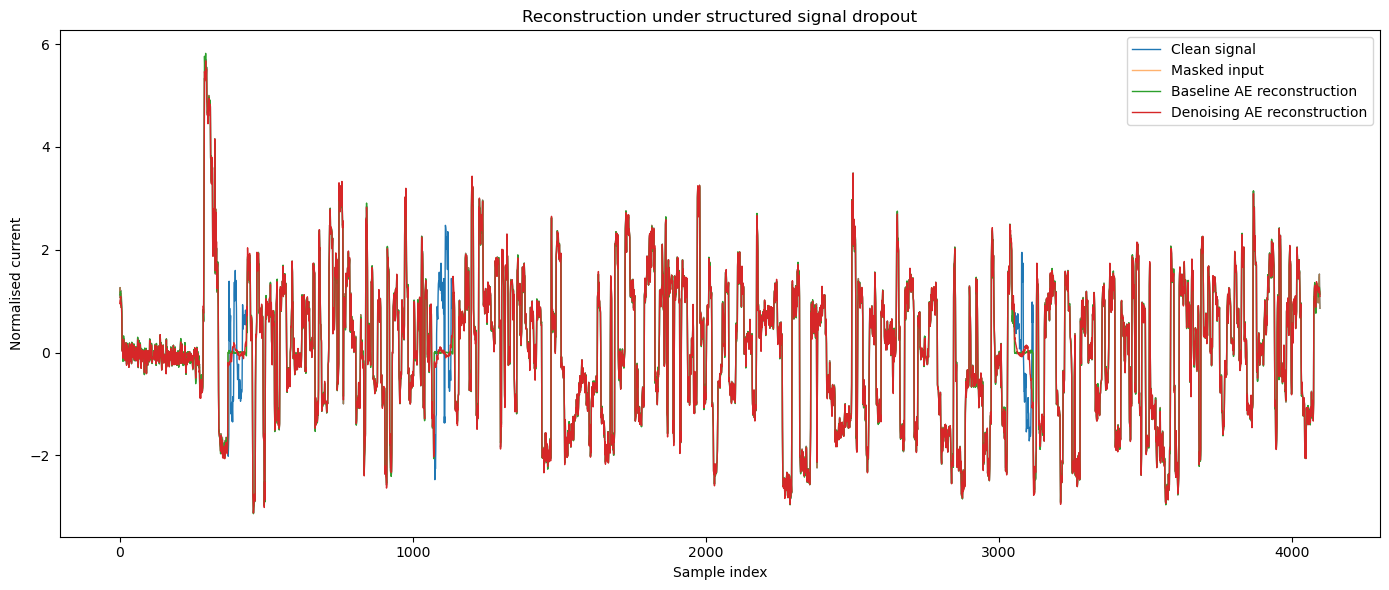

In [39]:
indx = 0

x_clean = torch.tensor(X_test[indx], dtype=torch.float32).unsqueeze(0).to(device)
x_masked = corrupt(x_clean, mode="mask", p=0.05, block=64)

with torch.no_grad():
    y_base = model(x_masked).cpu().numpy()[0]
    y_deno = denoise_model(x_masked).cpu().numpy()[0]

x_clean_np  = x_clean.cpu().numpy()[0]
x_masked_np = x_masked.cpu().numpy()[0]

plt.figure(figsize=(14, 6))
plt.plot(x_clean_np,  label="Clean signal", linewidth=1)
plt.plot(x_masked_np, label="Masked input", linewidth=1, alpha=0.6)
plt.plot(y_base,      label="Baseline AE reconstruction", linewidth=1)
plt.plot(y_deno,      label="Denoising AE reconstruction", linewidth=1)
plt.title("Reconstruction under structured signal dropout")
plt.xlabel("Sample index")
plt.ylabel("Normalised current")
plt.legend()
plt.tight_layout()
plt.show()